In [1]:
import os
os.environ['PYTHONHASHSEED'] = '0'
import numpy as np
np.random.seed(12)
import random as rn
rn.seed(123)
import tensorflow as tf
tf.random.set_seed(1234)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
import tensorflow.python.keras.backend as K
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

In [2]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Bidirectional, Dense, Dropout, LSTM
from keras.models import Sequential
from keras import initializers
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Using TensorFlow backend.


In [3]:
# convert an array of values into a dataset matrix with zero padding
def create_dataset(dataset, look_back=1, pad=True):
    if pad:
        dataset_pad = np.pad(dataset, ((look_back, look_back), (0, 0)), mode='edge')
    else:
        dataset_pad = dataset
        
    dataX = []
    for i in range(len(dataset_pad)-2*look_back):
        a = dataset_pad[i:(i+2*look_back+1), :]
        dataX.append(a)
    return np.array(dataX)

In [4]:
# read data
df_raw = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_test_real = pd.read_csv('real_test_result.csv')

# feature engineer
df_cln = df_raw.replace(['-999', -999], np.nan)
df_cln.dropna(inplace=True)
df_cln.drop(['CAL'], axis=1, inplace=True)

df_test = df_test.replace(['-999', -999], np.nan)
df_test.dropna(inplace=True)
df_test.drop(['CAL'], axis=1, inplace=True)

# discard outlier
df_cln = df_cln.drop(df_cln[df_cln.CNC > 40].index)

In [5]:
# set input size
pad_size = 0
time_steps = 2*pad_size + 1
n_features = len(df_cln.columns) - 2 

# train + validation set
X_all = df_cln.drop(['DTC', 'DTS'], axis=1)
y_all = df_cln[['DTC', 'DTS']].values

# train-validation data split
train_index = int(0.99 * len(X_all))
X_train, X_valid = X_all[:train_index], X_all[train_index:]
y_train, y_valid = y_all[:train_index], y_all[train_index:]
print('Training set has {} samples, validation set has {} samples.'.format(X_train.shape[0], X_valid.shape[0]))

# reshape
X_train = create_dataset(X_train, pad_size)
X_valid = create_dataset(X_valid, pad_size)

# test set
X_test = create_dataset(df_test.values, pad_size)
y_test = df_test_real.values

Training set has 20316 samples, validation set has 206 samples.


In [6]:
# initialize weights
kernel_initializer = initializers.glorot_uniform(seed=0)
recurrent_initializer = initializers.Orthogonal(gain=1.0, seed=0)

# define model
model = Sequential()
model.add(Bidirectional(LSTM(64, kernel_initializer=kernel_initializer,
                            recurrent_initializer=recurrent_initializer, bias_initializer='zeros'),
                            input_shape=(time_steps, n_features)))
model.add(Dropout(0.5))
model.add(Dense(2, kernel_initializer=kernel_initializer, bias_initializer='zeros', activation='linear'))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 128)               36352     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 36,610
Trainable params: 36,610
Non-trainable params: 0
_________________________________________________________________


In [7]:
start = time()

# fit model
np.random.seed(12)
rn.seed(123)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10)
earlystopper = EarlyStopping(monitor='val_loss', patience=40)
history = model.fit(X_train, y_train, batch_size=32, epochs=60, callbacks=[earlystopper],
          validation_data=(X_valid, y_valid))

end = time()
runtime = str(datetime.timedelta(seconds=int(end-start)))
print('Runtime: ' + runtime)

Train on 20316 samples, validate on 206 samples
Epoch 1/60
20316/20316 [==============================] - 4s 177us/step - loss: 16018.0992 - val_loss: 1495.1127
Epoch 2/60
20316/20316 [==============================] - 3s 127us/step - loss: 7820.6133 - val_loss: 110.4618
Epoch 3/60
20316/20316 [==============================] - 3s 129us/step - loss: 5120.5029 - val_loss: 447.7534
Epoch 4/60
20316/20316 [==============================] - 2s 120us/step - loss: 3800.8701 - val_loss: 967.6156
Epoch 5/60
20316/20316 [==============================] - 2s 122us/step - loss: 2922.0271 - val_loss: 1551.0928
Epoch 6/60
20316/20316 [==============================] - 2s 121us/step - loss: 2383.7367 - val_loss: 1075.2048
Epoch 7/60
20316/20316 [==============================] - 2s 121us/step - loss: 1981.1687 - val_loss: 1294.1858
Epoch 8/60
20316/20316 [==============================] - 2s 121us/step - loss: 1702.2732 - val_loss: 1080.1501
Epoch 9/60
20316/20316 [==============================] - 

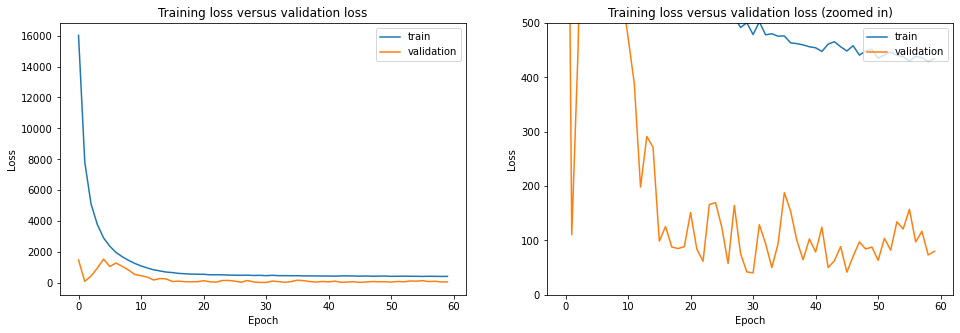

In [8]:
def loss_plot(history, limit):
    plt.subplots(nrows=1, ncols=2, figsize=(16,5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.title('Training loss versus validation loss')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim([0, limit])
    plt.legend(['train', 'validation'], loc='upper right')
    plt.title('Training loss versus validation loss (zoomed in)')
    plt.show()
    
loss_plot(history, limit=500)

Train RMSE 14.3384, validation RMSE 8.9447


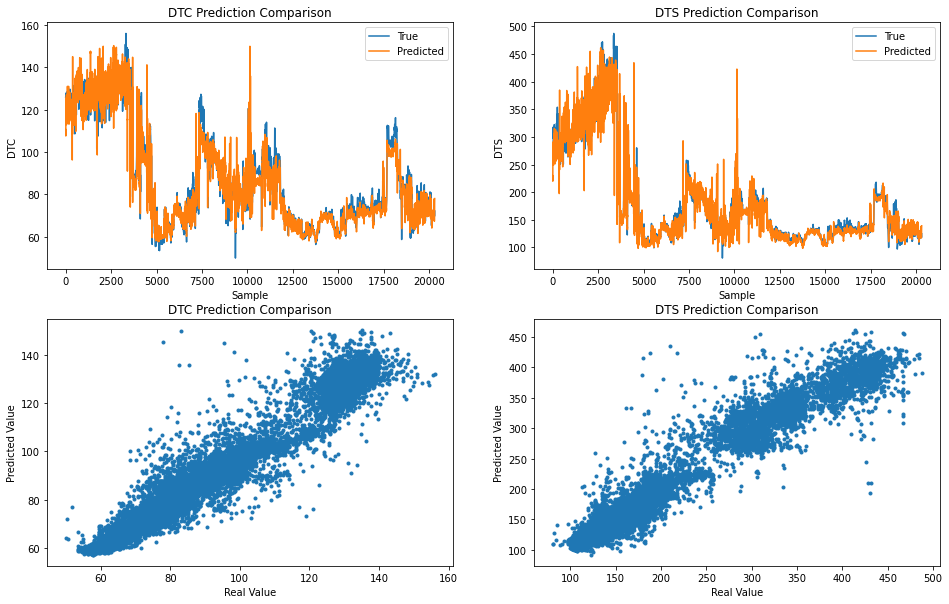

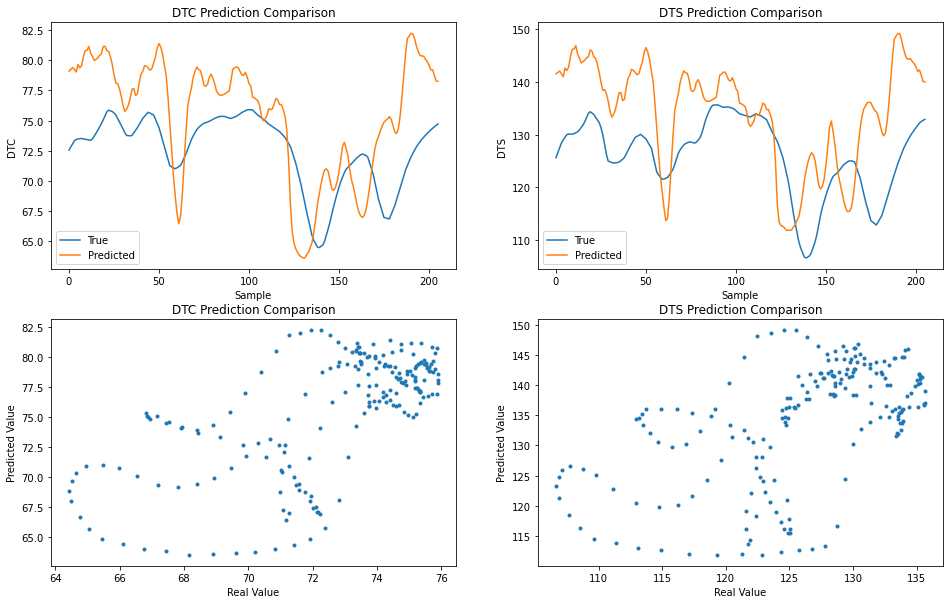

In [9]:
def result_plot(y_predict, y_real):
    plt.subplots(nrows=2, ncols=2, figsize=(16,10))
    plt.subplot(2, 2, 1)
    plt.plot(y_real[:, 0])
    plt.plot(y_predict[:, 0])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('DTC')
    plt.title('DTC Prediction Comparison')

    plt.subplot(2, 2, 2)
    plt.plot(y_real[:, 1])
    plt.plot(y_predict[:, 1])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('DTS')
    plt.title('DTS Prediction Comparison')
    
    plt.subplot(2, 2, 3)
    plt.plot(y_real[:, 0], y_predict[:, 0], '.')
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    plt.title('DTC Prediction Comparison')
    
    plt.subplot(2, 2, 4)
    plt.plot(y_real[:, 1], y_predict[:, 1], '.')
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    plt.title('DTS Prediction Comparison')

    plt.show()

# check the accuracy of predicted data
p_train = model.predict(X_train)
p_valid = model.predict(X_valid)

rmse_train = np.sqrt(np.square(np.subtract(y_train, p_train)).mean())
rmse_valid = np.sqrt(np.square(np.subtract(y_valid, p_valid)).mean())
print('Train RMSE {:.4f}, validation RMSE {:.4f}'.format(rmse_train, rmse_valid))

# plot results
result_plot(p_train, y_train)
result_plot(p_valid, y_valid)

Testing set RMSE 14.6015


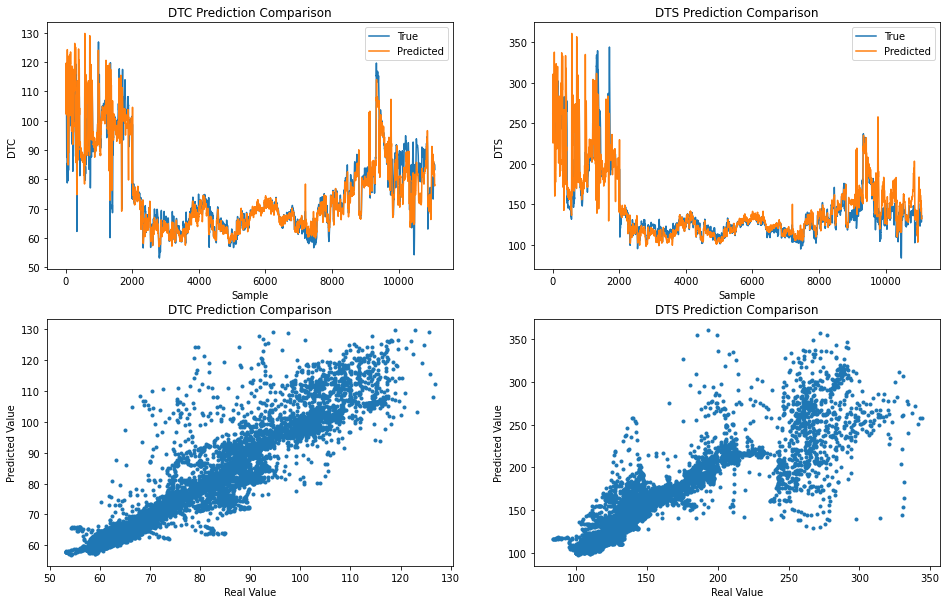

In [10]:
# run the prediction
p_test = model.predict(X_test)

# calculate metric
rmse_test = np.sqrt(np.square(np.subtract(y_test, p_test)).mean())
print('Testing set RMSE {:.4f}'.format(rmse_test))

# plot results
result_plot(p_test, y_test)

# export results to csv
output_result = pd.DataFrame({'DTC':p_test[:,0], 'DTS':p_test[:,1]})
output_result.to_csv(path_or_buf='Rocket_Team_submission.csv', index=False)